In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras.utils import to_categorical

# Table of Contents

## Data collection

For this project our data source was Flickr 8k images, this you can download from Flickr website or available in other forums

https://github.com/goodwillyoga/Flickr8k_dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd '/content/drive/My Drive/AAIC/Image to Text'

/content/drive/My Drive/AAIC/Image to Text


## Data Understanding

**Flickr8k.token.txt** has the Name of each Image along with its 5 captions

In [4]:
# load Name of each image along with its 5 captions
def load_doc(filename):
  if (filename == 'descriptions.txt'):
    %cd '/content/drive/My Drive/AAIC/Image to Text/'
  else:
    %cd '/content/drive/My Drive/AAIC/Image to Text/Flickr8k_text/'
	# open the file as read only
  file = open(filename, 'r')
	# read all text
  text = file.read()
	# close the file
  file.close()
  %cd '/content/drive/My Drive/AAIC/Image to Text'
  return text

filename = "Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])



/content/drive/My Drive/AAIC/Image to Text/Flickr8k_text
/content/drive/My Drive/AAIC/Image to Text
1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


**The text file looks as follows:**

***'image name #i <caption>', where 0≤i≤4***

In [ ]:
print(doc[:400])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wood


Create a dictionary for Imaged ID as key and description as value using below blockof code

In [5]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id, i.e. remove jpeg#i from file name
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [6]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

## Text preprocessing.


1.   Convert everything to lower case
2.   Remove special characters (like ‘%’, ‘$’, ‘#’)
3.   Remove words which contain numbers ('hey123')



In [7]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [8]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

**Create a vocabulary with all the unique words in the given data**

OF 8k * 5 = 40000 captions there are 8763 unique words

In [9]:
# Get vocabulary of unique words from descriptions dictionary
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [10]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

## Load Training Data

Read the images ID information from **Flickr_8k.trainImages.txt** file



In [11]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = '/content/drive/My Drive/AAIC/Image to Text/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

/content/drive/My Drive/AAIC/Image to Text/Flickr8k_text
/content/drive/My Drive/AAIC/Image to Text
Dataset: 6000


In [12]:
# Below path contains all the images
images = '/content/drive/My Drive/AAIC/Image to Text/Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

1. **train_images**: This has the image names of training set. For ex, '3155365418_43df5486f9.jpg'

2. **train_img**: This variable has the <path>/image_name/. For ex, *'content/drive/My Drive/AAIC/Image to Text/Flicker8k_Dataset/2717686269_80c4b5ac9e.jpg'*



In [14]:
# Below file conatains the names of images to be used in train data
train_images_file = '/content/drive/My Drive/AAIC/Image to Text/Flickr8k_text/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [16]:
train_img[5]

'/content/drive/My Drive/AAIC/Image to Text/Flicker8k_Dataset/3759492488_592cd78ed1.jpg'

In [17]:
# Below file conatains the names of images to be used in test data
test_images_file = '/content/drive/My Drive/AAIC/Image to Text/Flickr8k_text/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [ ]:
img

**Load the image description (captions) from descriptions.txt file**
descriptions.txt has the captions information for all images. From this file we will filter out captions of training set. We will also add start_seq and end_seq at the beginning and end of each caption

In [18]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
  doc = load_doc(filename)
  descriptions = dict()
  for line in doc.split('\n'):
		# split line by white space
    tokens = line.split()
		# split id from description
    image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
    if image_id in dataset:
      # create list
      if image_id not in descriptions:
        descriptions[image_id] = list()
        # wrap description in tokens
      desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
      descriptions[image_id].append(desc)
  return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

/content/drive/My Drive/AAIC/Image to Text
/content/drive/My Drive/AAIC/Image to Text
Descriptions: train=6000


In [ ]:
train_descriptions

## Inception V3 Model: Images to Vector
we will be using a Inception V3 model whose input vector is of 299x299. It was designed to classify images for Imagenet dataset. However, we will remove SOFTMAX layer as we need the output vector from Inception V3, which can be used as input to our Decoder(LSTM) layer for Image to Text conversion.

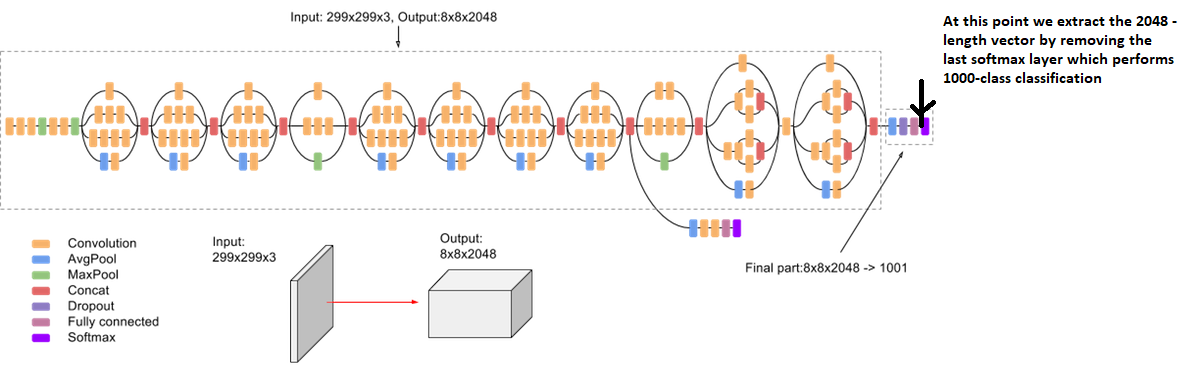

In [20]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [21]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

96124928/96112376 [==============================] - 1s 0us/step


In [22]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [23]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [24]:
# Call the funtion to encode all the train images
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 3349.043564081192


In [25]:
# Save the bottleneck train features to disk
with open("/content/drive/My Drive/AAIC/Image to Text/Pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
  dump(encoding_train, encoded_pickle)

In [26]:
# Encode all the test images
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 559.0065629482269


In [27]:
# Save the bottleneck test features to disk
with open("/content/drive/My Drive/AAIC/Image to Text/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

In [28]:
train_features = load(open("/content/drive/My Drive/AAIC/Image to Text/Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [29]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [30]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [31]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [32]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [33]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


## Data Generator Function

* Step 1: How to you formualte the input for our Deep Learning Model?
* Step 2: Need for data generator and how to implement it?

**Step 1:**
1. The aim of this case study is, for a given input image we have to predict the text of the objects in that image in a meanigful way. For example, in the below image we observe that ' The white cat is walking on the road'. Now when this imae is given as input we have to predict the sequence of words. So input is image and output is a sequence of words.

2. We will conver the input image to a vector using Inception V3 model.

3. For training our deep learning model we need inout vector (images) and also predictor variable i.e captions. We will supply indexes instead of words.

4. Also, lenght of captions can be different, hence we will find the maximum lenght of input sentence in this case 34. And for other sentences we will apply zero padding

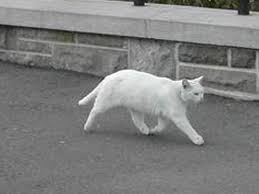


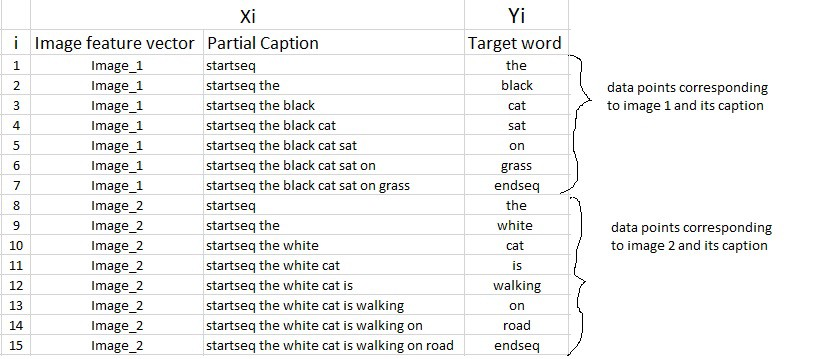

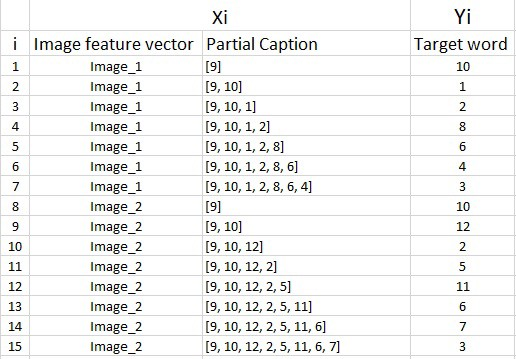

**After Zero padding**
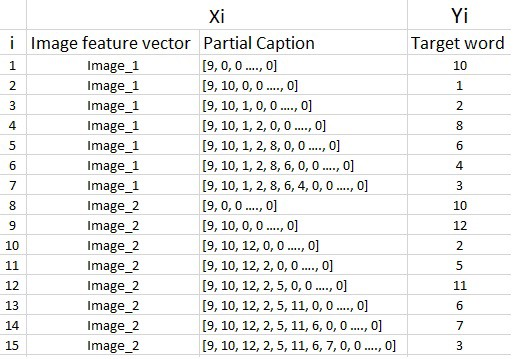

### Need for data generator and how to implement it?

Training dataset has 6000 images, and each having 5 captions. This makes a total of 30000 images and captions pairs. when we convert the captions to a sequence information like above there could be >250000 data points. So how can we contruct a data matrix?

Size of the data matrix = n*m
Where n-> number of data points (assumed as 210000)
m-> length of each data point
m= Length of image vector(2048) + Length of partial caption(x).
m = 2048 + x
what is the value of x?
Well you might think it is 34, but no wait, it’s wrong.
Every word (or index) will be mapped (embedded) to higher dimensional space through one of the word embedding techniques.

We will use GLOVE word embedding, to convert the 34 indexes lenght sentence to 34*200 = 6800 lenght vector

Hence, m = 2048 + 6800 = 8848.
Finally, size of data matrix= 250000 * 8848= 2,212,000,000 blocks.

As RAM may not be able to handle this amount of information, we will use Generator functions. It’s like an iterator which resumes the functionality from the point it left the last time it was called.

In [35]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
  X1, X2, y = list(), list(), list()
  n=0
  # loop for ever over images
  while 1:
    for key, desc_list in descriptions.items():
      n+=1
      # retrieve the photo feature
      photo = photos[key+'.jpg']
      for desc in desc_list:
        # encode the sequence
        seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
        # split one sequence into multiple X, y pairs
        for i in range(1, len(seq)):
          # split into input and output pair
          in_seq, out_seq = seq[:i], seq[i]
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          # encode output sequence
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          # store
          X1.append(photo)
          X2.append(in_seq)
          y.append(out_seq)
          # yield the batch data
          if n==num_photos_per_batch:
            yield [np.array(X1), np.array(X2)], np.array(y)
            X1, X2, y = list(), list(), list()
            n=0
    #return np.array(X1), np.array(X2), np.array(y)

we will map the every word (index) to a 200-long vector and for this purpose, we will use a pre-trained GLOVE Model

for all the 1652 unique words in our vocabulary, we create an embedding matrix which will be loaded into the model before training

In [36]:
# Load Glove vectors
glove_dir = '/content/drive/My Drive/AAIC/Image to Text/'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [37]:
embedding_dim = 200

# Get 200-dim dense vector for each of the words in our vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [38]:
embedding_matrix.shape

(1652, 200)

## Model Architecture

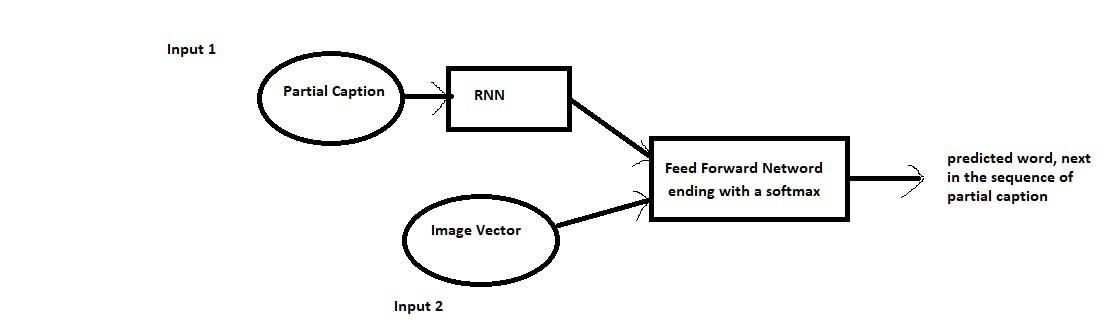

In [ ]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [41]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

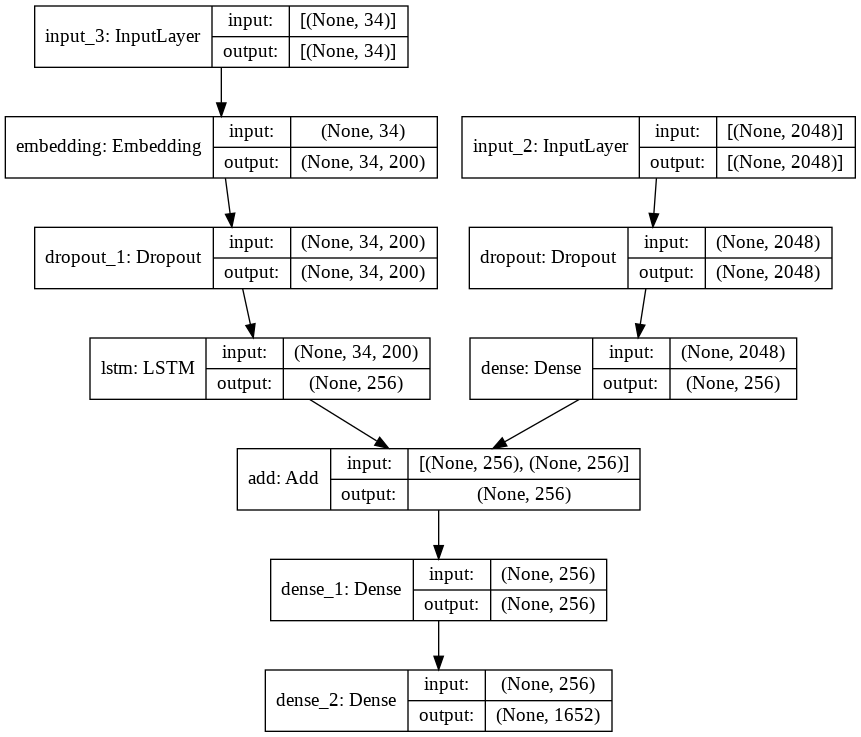

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True,)

we had created an embedding matrix from a pre-trained Glove model which we need to include in the model before starting the training:

In [42]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [43]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

Input_1 -> Partial Caption

Input_2 -> Image feature vector

Output -> An appropriate word, next in the sequence of partial caption provided in the input_1 (or in probability terms we say conditioned on image vector and the partial caption)

In [44]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [45]:
from tensorflow.keras.utils import to_categorical
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

2000/2000 [==============================] - 586s 287ms/step - loss: 4.6013


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2000/2000 [==============================] - 568s 284ms/step - loss: 2.7217


In [46]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1000/1000 [==============================] - 478s 478ms/step - loss: 2.5206


In [47]:
model.save_weights('./model_weights/model_20.h5')

In [ ]:
model.load_weights('./model_weights/model_20.h5')

In [49]:
images = '/content/drive/My Drive/AAIC/Image to Text/Flicker8k_Dataset/'

In [50]:
with open("/content/drive/My Drive/AAIC/Image to Text/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [51]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

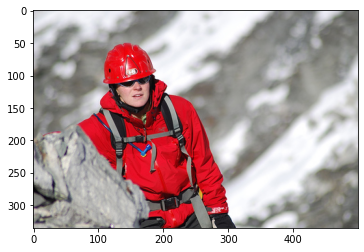

Greedy: man in red jacket is standing on snowy mountain


In [63]:
#z = 0
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))